# Setup

In [1]:
!pip install --upgrade yfinance
!pip install copulas
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
import random
import matplotlib.ticker as ticker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.6 MB/s eta 0:00:00


# Redemption Stress Test Model


## ETF Flow Estimation

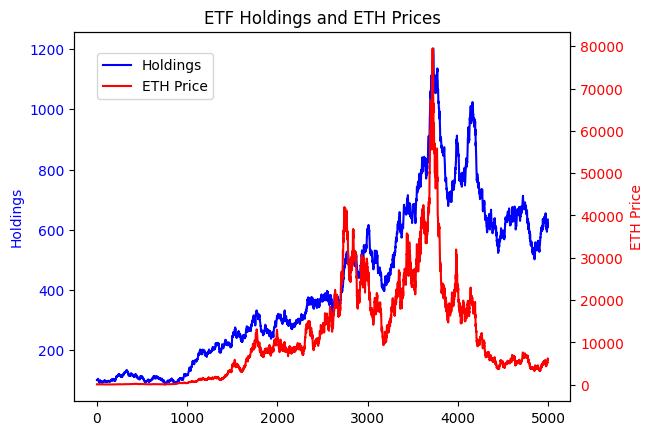

In [2]:
# Simulation Parameters:

# For replicability

np.random.seed(42)

# number of draws to simluate flow and redemptions
ndraws = 5000

# Impulse Response (in opposite direction, from oldest to newest response)
# This is how flow_change responds to lags of Asset Returns (starting from lag6 to lag1 and lag0)
# These estimate come from the Impulse Response Analysis section
impulse_response = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.05]
impulse_length = len(impulse_response)

# Define volatility of eth returns. You can run the code below to see that ETH
# volatility is about 4% daily over the last 7 years.
eth_vol = 0.04

'''
# Define Underlying Asset Volatility # ASSUMPTION ETH returns are lognormal
price = yf.download(f'ETH-USD', start="2018-01-01", end="2025-02-15")
price.index = pd.to_datetime(price.index)
price = price['Close'][f'ETH-USD']
price
price[f'ETH_Returns'] = price.to_frame().pct_change()
eth_vol = price['ETH_Returns'].std()[0]
print(eth_vol)
'''

# Define daily Noise flow Volatility. This comes from the volatility of flow changes
# for BTC and Gold ETF. See section on BTC and Gold ETF below.
red_vol = 0.01

# Create Input Variables to ETF Flow
# ASSUMPTION: Flow Noise Flow and ETH returns are lognormally distributed
# ASSUMPTION: I give a tilt of 15% per year in returns to ETH.
# ETH beta is about 2, which means an expected return of about 15%
eth_returns = np.exp(np.random.normal(loc = 0.15/252, scale = eth_vol, size = ndraws))-1
holdings_noise_flow_pct = np.exp(np.random.normal(loc = 0, scale = red_vol, size = ndraws))-1

# Start Simulation with value of 100. Since I am adding an impulse response of length
# impulse_length, I need to start the first impulse_length obs as 100.
initial_value = 100  # Starting asset value
holdings_amount = [initial_value]*impulse_length
holdings_amount_pct_change = [initial_value]*impulse_length

# This is the core of the simulation. For each date, (starting after impulse length)
# I first estimate the new flow. The new flow is made of two components: (1) the impulse response
# of the last 7 ETH lagged returns, and (2) a noise component.
# The impulse response is simply the sum of the dot product of the past 7 days
# returns, and the impulse response coefficients.
# Once we knwo the new flow (in percentage), we create the new holdings (past holding *(1+new flow and new noise flow))

for i in range(impulse_length, ndraws):
    new_flow_pct = np.sum(np.dot(eth_returns[i-impulse_length+1:i+1], impulse_response))
    new_holdings = holdings_amount[-1] * (1 + new_flow_pct + holdings_noise_flow_pct[i])
    holdings_amount.append(new_holdings)

holdings_amount_pct_change = [holdings_amount[i]/holdings_amount[i-1]  - 1 for i in range(1, len(holdings_amount))]


# Finally, I plot ETH price and ETF Holdings.

# Create a figure and axes
fig, ax1 = plt.subplots()

# Plot holdings amount on the primary y-axis (ax1)
ax1.plot(holdings_amount, color='blue', label='Holdings')
ax1.set_ylabel('Holdings', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis (ax2) for ETH returns
ax2 = ax1.twinx()
ax2.plot(100 + 100*((1+eth_returns).cumprod()-1), color='red', label='ETH Price')
ax2.set_ylabel('ETH Price', color='red')
ax2.tick_params('y', labelcolor='red')

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))

# Set the title and x-axis label
plt.title('ETF Holdings and ETH Prices')
plt.xlabel('Time')  # Adjust if you have a specific time variable

# Display the plot
plt.show()


# Queue Modeling

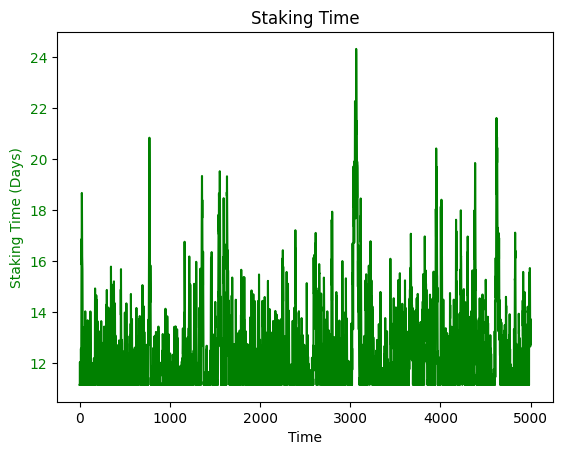

In [3]:
# The second step of the process is to simulate how long it takes to unstake ETH.
# More info on staking timing can be found here
#https://figment.io/insights/understanding-the-timeline-staking-and-unstaking-ethereum/

# This is exit request time (5 epoch = 32 minutes), plus 256 epochs (27.3 hours),
# plus exit time plus withdrawal sweeping.
# I model exit queue time as normally distributed, with a high negative correlation with
# ETP holding changes. Exit time is modeled so that a 100% ETP withdrawal would take 40days (9)with AUM of $10B).
# Before pectra, sweep times are abotu 10 days. this is the max time to get swept.
# This number would go down (maybe 30% or more) after pectra.
# staking time is a brownian motion, with a minimum of maxdays + 32 min +27h.

#maxdays is for the withdrawal sweep time.
maxdays = 10

#Need to model exit queue times.

# exit_time is the exit time queue
exit_time = np.maximum(0,-40*np.array(holdings_amount_pct_change) + np.random.normal(loc = 0.1, scale = 1.5, size = ndraws-1))

staking_time =[exit_time[0]]
for i in range(1, len(exit_time)):
  # every day, I have yesterday's staking time less one day, plus more time because of the added exit time.
  staking_time.append(np.maximum(0,staking_time[i-1] + exit_time[i] -1))

# add the fixed components of staking time
staking_time = np.array(staking_time) + maxdays + 32/(60*24) + 27.3/24

# Create a figure and axes
fig, ax1 = plt.subplots()

# Plot staking time on the primary y-axis (ax1)
ax1.plot(staking_time, color='green', label='Staking Time (Days)')
ax1.set_ylabel('Staking Time (Days)', color='green')
ax1.tick_params('y', labelcolor='green')

# Set the title and x-axis label
plt.title('Staking Time')
plt.xlabel('Time')

# Display the plot
plt.show()

# Step 3. Estimate Delivery Failure

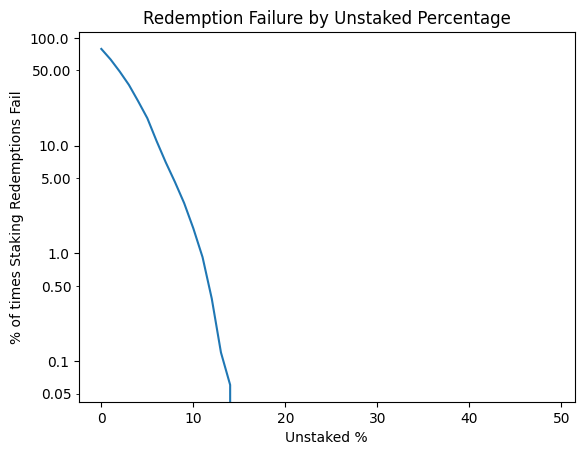

In [4]:
# The final step is to estimate how often ETH is not delivered because the ETF runs
# out of unstaked ETH, and the queue prevents the ETF issuer to unstake ETH

above_threshold_percentage = []

#Loop for each threshold from 0% to 50%. For each threshold level, I loop through the draws (i)
# to find the wait time (staking_time[i]) and see whether the maximum drawdown of holding during
# that waiting period is greater than the threshold (i.e. delivery failure).
# (small note: when I loop through the draws, I stop a bit earlier than the end of times,
# because I need to look forward until the end of the waiting period)
for threshold in range(0,50,1):
  redemption = []

  for i in range(len(staking_time)-round(np.max(staking_time))):
      wait = int(np.ceil(staking_time[i]))
      redemption.append((holdings_amount[i] - np.min(holdings_amount[i:i+wait]))/holdings_amount[i])


  above_threshold_percentage.append(sum(1 for x in redemption if x > threshold/100) / len(redemption) * 100)

# Plot graph of delivery failure over threshold

plt.plot(above_threshold_percentage)
plt.xlabel('Unstaked %')
plt.ylabel('% of times Staking Redemptions Fail')
plt.title('Redemption Failure by Unstaked Percentage')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1.0])) # Major ticks at powers of 10
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(0, 10,5))) # Minor ticks at intermediate values
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%3.1f"))  # Format minor tick labels
plt.gca().yaxis.set_minor_formatter(ticker.FormatStrFormatter("%3.2f"))  # Format minor tick labels

plt.show()


# Validation Exercise

In [5]:
# Functions Definition

# This Function loads ETF data, cleans date field, adds missing trading days, and define returns
def load_data(fund, start_date):
  flow = pd.read_csv(f'flow_{fund}.csv', na_values=['-'], index_col='DateTime', thousands=',')
  # round up date
  # Round the next day down to the nearest day
  flow = flow[[ 'holdings']]
  flow.index = pd.to_datetime(flow.index).ceil('D') - datetime.timedelta(days=1)
  flow = flow.loc[flow.index > pd.to_datetime(start_date)]

  all_trading_days = pd.date_range(start=flow.index.min(), end=flow.index.max(), freq='B') # 'B' for business days
  all_trading_days = pd.DataFrame({'DateTime': all_trading_days})
  flow = pd.merge(all_trading_days, flow, left_on='DateTime', right_on='DateTime', how='left')
  flow['holdings'] = flow['holdings'].fillna(method='ffill')
  flow.dropna(inplace=True)
  flow['flow_change'] = flow['holdings'].pct_change()
  flow.dropna(inplace=True)

  return flow


# This function plots a histogram of flow changes.
def plot_hist(flow):
  ax = flow['flow_change'].hist(bins=100, density=True)
  flow['flow_change'].plot.kde(ax=ax, bw_method=0.2)
  plt.show()


# This function loads up ETF flow data (flow), download the underlying asset (token) data, merge
# the two datasets, compute asset returns, and lags of asset returns (lags).
def merge_prices(flows, token, lags):
  price = yf.download(f'{token}', start="2020-01-01", end="2025-02-15")
  price.index = pd.to_datetime(price.index)
  price = price['Close'][f'{token}']
  flows = flows.merge(price, left_on = 'DateTime', right_index = True, how='left')
  flows[f'{token}_Returns'] = flows[f'{token}'].pct_change()

  # Create lagged return variables
  for i in range(1, lags + 1):
      flows[f'{token}_Returns_Lag{i}'] = flows[f'{token}_Returns'].shift(i)

  # Remove rows with NaN values created by lagging
  flows = flows.dropna(subset = [f'{token}_Returns_Lag{i}' for i in range(1, lags + 1)] + [f'{token}_Returns', 'flow_change'])
  return flows



# This functions finds the impulse response, by running a regression of flow_changes
# over lags of token returns.
def run_regression(flows, token, lags):
  # prompt: run a regression where the y is the total btc flow, and the x are lags of btc returns

  # Define the independent and dependent variables
  X = flows[[f'{token}_Returns'] + [f'{token}_Returns_Lag{i}' for i in range(1, lags + 1)]]
  y = flows['flow_change']

  # Add a constant to the independent variables
  X = sm.add_constant(X)

  # Fit the linear regression model
  model = sm.OLS(y, X).fit()

  # Print the model summary
  print(model.summary())
  return model



# This functions plots the impulse response coefficients, and the cumulative impulse response.
def plot_coefficients(model):
  # Get the coefficients and confidence intervals
  coefficients = model.params[1:]
  conf_int = model.conf_int(alpha=0.05)[1:]  # 95% confidence interval

  # Create a plot
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot the coefficients
  ax.plot(coefficients.index, coefficients.values, 'o', label='Impulse Response Coefficients')

  # Plot the confidence intervals
  ax.vlines(coefficients.index, conf_int[0], conf_int[1], linestyles='dashed', label='95% Confidence Interval')

  # Customize the plot
  ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5) # add a horizontal line at y=0
  ax.set_xlabel("Returns")
  ax.set_ylabel("Impulse Response")
  ax.set_title("Regression Coefficients with 95% Confidence Intervals")
  ax.tick_params(axis='x', rotation=45, labelsize=8)
  ax.legend()
  plt.tight_layout()
  plt.show()

  # Cumulative Coefficients
  # Create the plot
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot the coefficients
  ax.plot(coefficients.index, coefficients.values, 'o', label='Impulse Response Coefficients')

  # Plot the confidence intervals
  ax.vlines(coefficients.index, conf_int[0], conf_int[1],
            linestyles='dashed', label='95% Confidence Interval')

  # Calculate and plot cumulative coefficients
  cumulative_coefficients = coefficients.cumsum()
  ax.plot(cumulative_coefficients.index, cumulative_coefficients.values,
          marker='o', linestyle='-', label='Cumulative Impluse Response')

  # Customize the plot
  ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
  ax.set_xlabel("Returns")
  ax.set_ylabel("Impulse Response")
  ax.set_title("Regression Coefficients with 95% Confidence Intervals")
  ax.tick_params(axis='x', rotation=45, labelsize=8)
  ax.legend()
  plt.tight_layout()
  plt.show()



Using data from Bitcoin spot and futures ETF, and gold ETF, how often we experienced an outflow greater than 5,10,15,20% in 5 or 10 days?


## Unstaking Exit Time and ETH returns

In [6]:
#Correlation between ETH returns and queue time
# data about queue time comes from
#https://github.com/etheralpha/validatorqueue-com/blob/main/historical_data.json
#data is only about exit queue time, not withdrawal sweep time, but that is almost
#constant over time, so it would not affect the analysis

queue_time = pd.read_json('eth_queue_data.json')
queue_time.rename(columns = {'date': 'DateTime'}, inplace = True)
queue_time['DateTime'] = pd.to_datetime(queue_time['DateTime'])
queue_time.set_index('DateTime', inplace = True)
queue_time['flow_change'] = queue_time['exit_wait']
queue_eth = merge_prices(queue_time, 'ETH-USD', 10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-5-c06c5b08c2ad>:37: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  flows[f'{token}_Returns'] = flows[f'{token}'].pct_change()


                            OLS Regression Results                            
Dep. Variable:            flow_change   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.3335
Date:                Thu, 06 Mar 2025   Prob (F-statistic):              0.978
Time:                        15:14:30   Log-Likelihood:                -332.81
No. Observations:                 630   AIC:                             689.6
Df Residuals:                     618   BIC:                             743.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.09

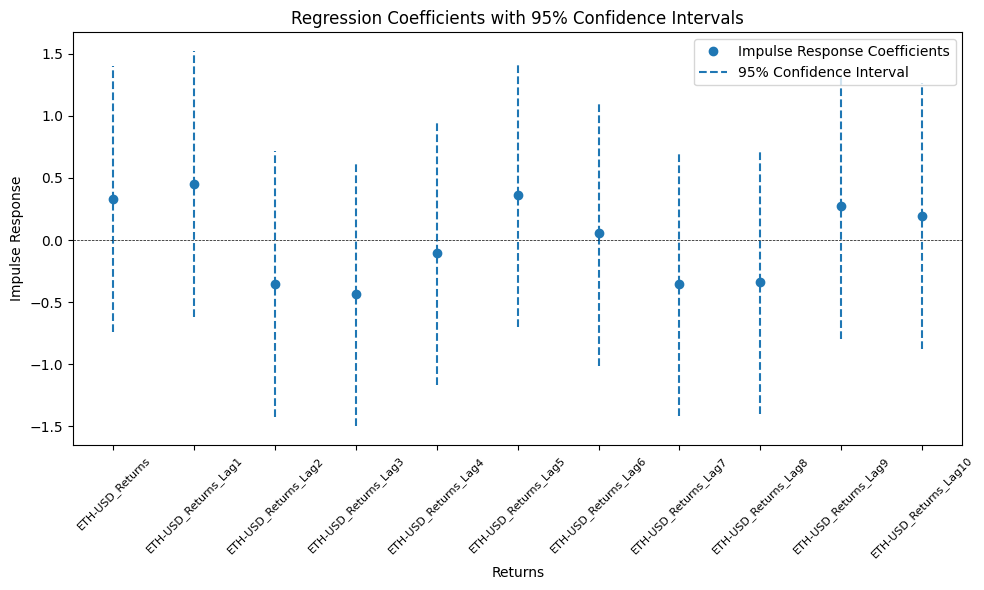

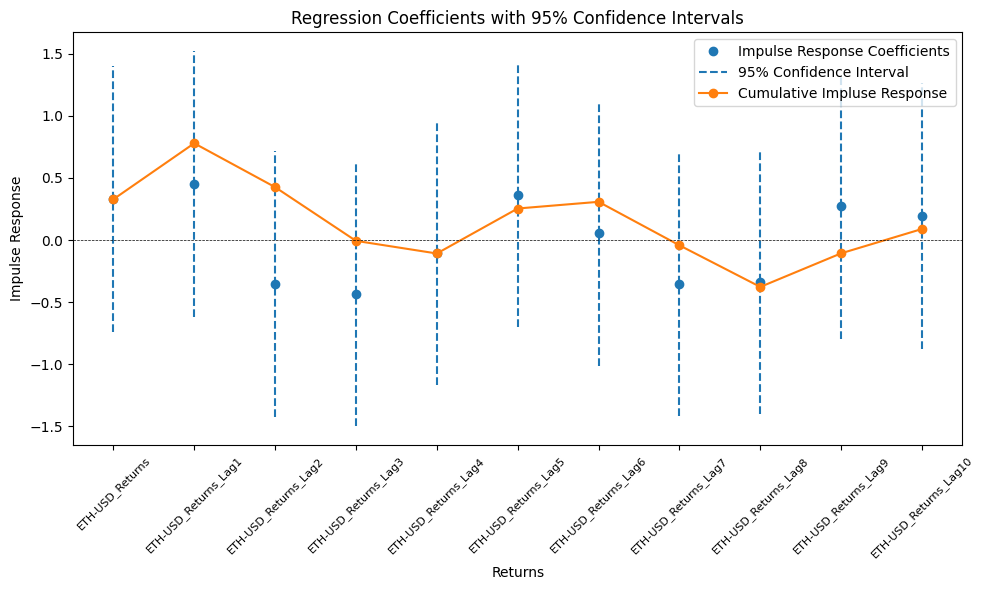

In [7]:
model = run_regression(queue_eth, 'ETH-USD', 10)
plot_coefficients(model)

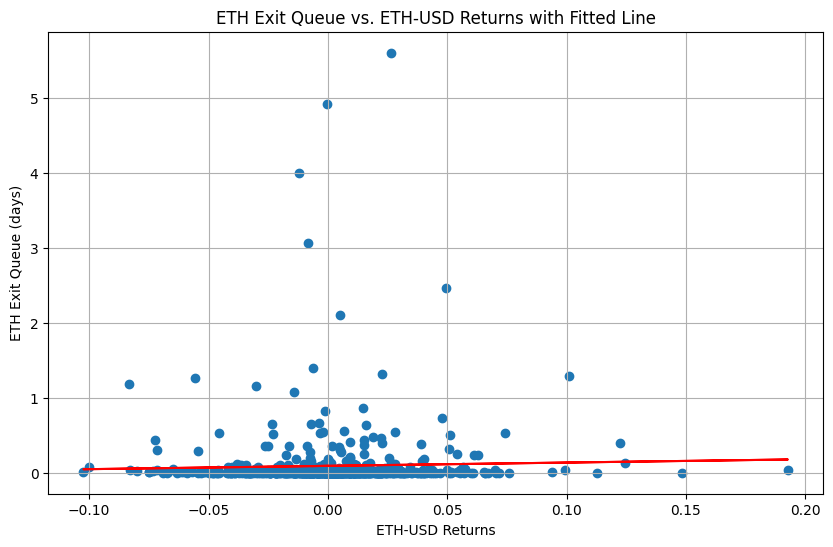

In [8]:

# Assuming 'queue_eth' DataFrame and 'model' are already defined from previous code

# Extract relevant data
X = queue_eth[['ETH-USD_Returns']].shift(1)[1:]
X = sm.add_constant(X)  # Add a constant term
y = queue_eth['flow_change'][1:]

# Fit the OLS model again to get the fitted values
model = sm.OLS(y, X).fit()
y_fitted = model.fittedvalues

# Plot the scatter plot with the fitted line
plt.figure(figsize=(10, 6))
plt.scatter(queue_eth['ETH-USD_Returns'].shift(1)[1:], queue_eth['flow_change'][1:], label='Actual Data')
plt.plot(queue_eth['ETH-USD_Returns'].shift(1)[1:], y_fitted, color='red', label='Fitted Line')
plt.xlabel('ETH-USD Returns')
plt.ylabel('ETH Exit Queue (days)')
plt.title('ETH Exit Queue vs. ETH-USD Returns with Fitted Line')
plt.grid(True)
plt.show()

## ETF Data

In [9]:
# Set starting date

spot_BTC_start = '2024-03-01'
futures_BTC_start = '2021-11-01'
gold_start = '2024-03-01'
spot_ETH_start = '2024-08-01'

# Load Flow Data for Bitcoin Spot ETFs.
flow_arkb = load_data('arkb', spot_BTC_start)
flow_bitb = load_data('bitb', spot_BTC_start)
flow_fbtc = load_data('fbtc', spot_BTC_start)
flow_gbtc = load_data('gbtc', spot_BTC_start)
flow_ibit = load_data('ibit', spot_BTC_start)

# Load Flow Data for Bitcoin Futures ETFs.
flow_bito = load_data('bito', futures_BTC_start)
flow_bito = flow_bito.replace([np.inf, -np.inf], np.nan)
flow_bito.dropna(inplace=True)

# Load Flow Data for Bitcoin Spot ETFs.
flow_etha = load_data('etha', spot_ETH_start)

# Load Flow Data for Gold ETFs.
# Data comes from https://en.macromicro.me/charts/23274/gld-fund-flow
flow_gold = pd.read_csv(f'flow_gold.csv', na_values=['HOLIDAY'], index_col='Date',
                   thousands=',')
flow_gold.index = pd.to_datetime(flow_gold.index)
flow_gold = flow_gold.applymap(lambda x: x.replace('$', '').replace('%', '').replace(',', '') if isinstance(x, str) else x)
flow_gold = flow_gold.apply(pd.to_numeric, errors='coerce')
flow_gold['flow_change'] = flow_gold['Total Net Asset Value Ounces in the Trust as at 4.15 p.m. NYT'].pct_change()
flow_gold['holdings'] = flow_gold['Total Net Asset Value Ounces in the Trust as at 4.15 p.m. NYT']
flow_gold['Gold_Returns'] = flow_gold['LBMA Gold Price'].pct_change()
flow_gold['etf_price_change'] = flow_gold['GLD Close'].pct_change()
flow_gold = flow_gold[2:]




<ipython-input-5-c06c5b08c2ad>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flow['holdings'] = flow['holdings'].fillna(method='ffill')
<ipython-input-5-c06c5b08c2ad>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flow['holdings'] = flow['holdings'].fillna(method='ffill')
<ipython-input-5-c06c5b08c2ad>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flow['holdings'] = flow['holdings'].fillna(method='ffill')
<ipython-input-5-c06c5b08c2ad>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flow['holdings'] = flow['holdings'].fillna(method='ffill')
<ipython-input-5-c06c5b08c2ad>:15: FutureWarning: Series.fillna with 'method' is dep

<ipython-input-10-acb58a546ea9>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outflow = pd.concat([outflow, new_row], ignore_index=True)
<ipython-input-10-acb58a546ea9>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outflow_5days = pd.concat([outflow_5days, new_row], ignore_index=True)
<ipython-input-10-acb58a546ea9>:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

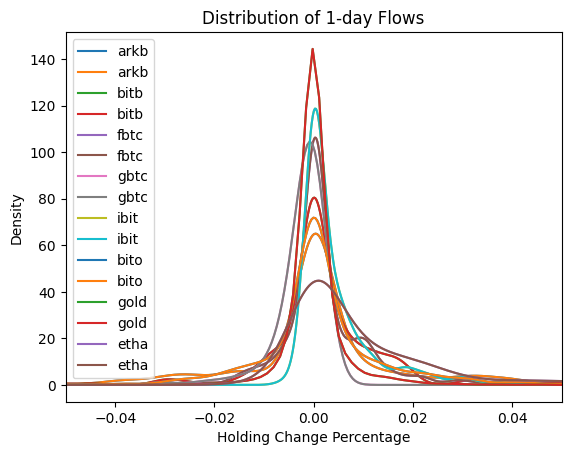

In [10]:

# For each ETF, plot hisogram of holding changes % (i.e. flow), compute stdev,
# and % times outflow is greater than 5%, 10%, 15%, 20%
outflow = pd.DataFrame(columns = ['fund','St.Dev.', '5%', '10%', '15%', '20%',])
outflow_5days = pd.DataFrame(columns = ['fund', '5%', '10%', '15%', '20%',])
outflow_10days = pd.DataFrame(columns = ['fund', '5%', '10%', '15%', '20%',])

databases = [flow_arkb, flow_bitb, flow_fbtc, flow_gbtc, flow_ibit, flow_bito, flow_gold, flow_etha]
database_names = ['arkb', 'bitb', 'fbtc', 'gbtc', 'ibit', 'bito', 'gold', 'etha']

fig, ax = plt.subplots()

for i, database in enumerate(databases):
    # Calculate the % of times daily flow greater than 5%, 10%, 15%, 20%
    new_row = pd.DataFrame({'fund': [database_names[i]],
                            'St.Dev.': [database['flow_change'].std()],
                            '5%': [len(database.loc[database['flow_change']<-0.05])/len(database)],
                            '10%': [len(database.loc[database['flow_change']<-0.10])/len(database)],
                            '15%': [len(database.loc[database['flow_change']<-0.15])/len(database)],
                            '20%': [len(database.loc[database['flow_change']<-0.20])/len(database)]})
    outflow = pd.concat([outflow, new_row], ignore_index=True)
    database['flow_change'].plot.kde(ax=ax, label=database_names[i], bw_method=0.2)

    # Calculate the % of times max drawdown for 5-day flow greater than 5%, 10%, 15%, 20%

    maxdraw = pd.DataFrame(columns = ['Date', 'max_drawdown'])
    empty_row = pd.DataFrame([[np.nan] * len(maxdraw.columns)], columns=maxdraw.columns)

    for j in range(len(database) - 5):
      maxdraw = pd.concat([maxdraw,empty_row], ignore_index=True)
      maxdraw.loc[j,'Date'] = np.nan
      maxdraw.loc[j,'max_drawdown'] = (database.reset_index().loc[j, 'holdings'] - np.min(database.reset_index().loc[j:j+5, 'holdings']))/database.reset_index().loc[j, 'holdings']

    new_row = pd.DataFrame({'fund': [database_names[i]],
                            '5%': [len(maxdraw.loc[maxdraw['max_drawdown']>0.05])/len(maxdraw)],
                            '10%': [len(maxdraw.loc[maxdraw['max_drawdown']>0.10])/len(maxdraw)],
                            '15%': [len(maxdraw.loc[maxdraw['max_drawdown']>0.15])/len(maxdraw)],
                            '20%': [len(maxdraw.loc[maxdraw['max_drawdown']>0.20])/len(maxdraw)]})
    outflow_5days = pd.concat([outflow_5days, new_row], ignore_index=True)

    # Calculate the % of times max drawdown for 10-day flow greater than 5%, 10%, 15%, 20%

    maxdraw = pd.DataFrame(columns = ['Date', 'max_drawdown'])

    for j in range(len(database) - 10):
      maxdraw = pd.concat([maxdraw,empty_row], ignore_index=True)
      maxdraw.loc[j,'Date'] = np.nan
      maxdraw.loc[j,'max_drawdown'] = (database.reset_index().loc[j, 'holdings'] - np.min(database.reset_index().loc[j:j+10, 'holdings']))/database.reset_index().loc[j, 'holdings']

    new_row = pd.DataFrame({'fund': [database_names[i]],
                            '5%': [len(maxdraw.loc[maxdraw['max_drawdown']>0.05])/len(maxdraw)],
                            '10%': [len(maxdraw.loc[maxdraw['max_drawdown']>0.10])/len(maxdraw)],
                            '15%': [len(maxdraw.loc[maxdraw['max_drawdown']>0.15])/len(maxdraw)],
                            '20%': [len(maxdraw.loc[maxdraw['max_drawdown']>0.20])/len(maxdraw)]})
    outflow_10days = pd.concat([outflow_10days, new_row], ignore_index=True)

    database['flow_change'].plot.kde(ax=ax, label=database_names[i], bw_method=0.2)


percentage_columns = ['St.Dev.', '5%', '10%', '15%', '20%']
outflow[percentage_columns] = outflow[percentage_columns].applymap(lambda x: f'{x*100:.2f}%')
outflow_5days[['5%', '10%', '15%', '20%']] = outflow_5days[['5%', '10%', '15%', '20%']] .applymap(lambda x: f'{x*100:.2f}%')
outflow_10days[['5%', '10%', '15%', '20%']] = outflow_10days[['5%', '10%', '15%', '20%']] .applymap(lambda x: f'{x*100:.2f}%')



plt.legend()
plt.title('Distribution of 1-day Flows')
plt.xlabel('Holding Change Percentage')
plt.ylabel('Density')
plt.xlim(-0.05, 0.05)
plt.show()



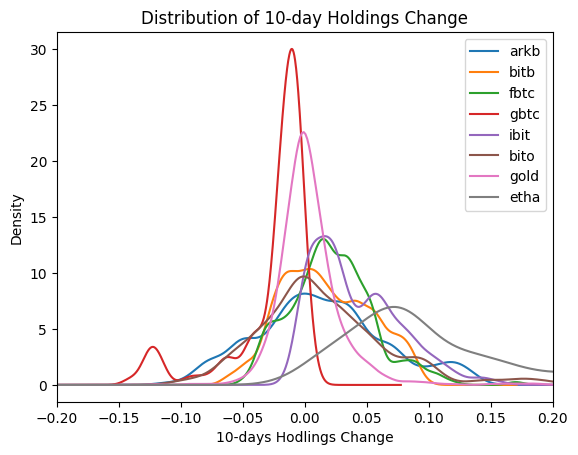

In [11]:
fig, ax = plt.subplots()

for i, database in enumerate(databases):

    # Calculate the % of times max drawdown for 5-day flow greater than 5%, 10%, 15%, 20%
    empty_row = pd.DataFrame([[np.nan] * len(maxdraw.columns)], columns=maxdraw.columns)

    maxdraw = pd.DataFrame(columns = ['Date', 'max_drawdown'])

    for j in range(len(database) - 10):
      maxdraw = pd.concat([maxdraw,empty_row], ignore_index=True)
      maxdraw.loc[j,'Date'] = np.nan
      maxdraw.loc[j,'max_drawdown'] = (database.reset_index().loc[j+10, 'holdings']-database.reset_index().loc[j, 'holdings'])/database.reset_index().loc[j, 'holdings']

#    database['flow_change'].plot.kde(ax=ax, label=database_names[i], bw_method=0.2)
    maxdraw['max_drawdown'].plot.kde(ax=ax, label=database_names[i], bw_method=0.2)



plt.legend()
plt.title('Distribution of 10-day Holdings Change')
plt.xlabel('10-days Hodlings Change')
plt.ylabel('Density')
plt.xlim(-0.2, 0.2)
plt.show()



In [12]:
outflow_5days

,fund,5%,10%,15%,20%
0,arkb,10.70%,0.00%,0.00%,0.00%
1,bitb,2.48%,0.00%,0.00%,0.00%
2,fbtc,0.00%,0.00%,0.00%,0.00%
3,gbtc,7.85%,4.13%,0.00%,0.00%
4,ibit,0.00%,0.00%,0.00%,0.00%
5,bito,5.05%,0.12%,0.00%,0.00%
6,gold,0.19%,0.10%,0.10%,0.00%
7,etha,0.00%,0.00%,0.00%,0.00%


In [13]:
outflow_10days

,fund,5%,10%,15%,20%
0,arkb,20.17%,1.26%,0.00%,0.00%
1,bitb,3.80%,0.00%,0.00%,0.00%
2,fbtc,0.00%,0.00%,0.00%,0.00%
3,gbtc,16.46%,9.70%,0.00%,0.00%
4,ibit,0.00%,0.00%,0.00%,0.00%
5,bito,13.70%,0.83%,0.00%,0.00%
6,gold,0.93%,0.13%,0.11%,0.00%
7,etha,0.00%,0.00%,0.00%,0.00%


# Impulse Response Analysis

## Spot BTC ETF

[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:            flow_change   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     3.705
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           5.26e-07
Time:                        15:15:40   Log-Likelihood:                 860.42
No. Observations:                 227   AIC:                            -1677.
Df Residuals:                     205   BIC:                            -1601.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

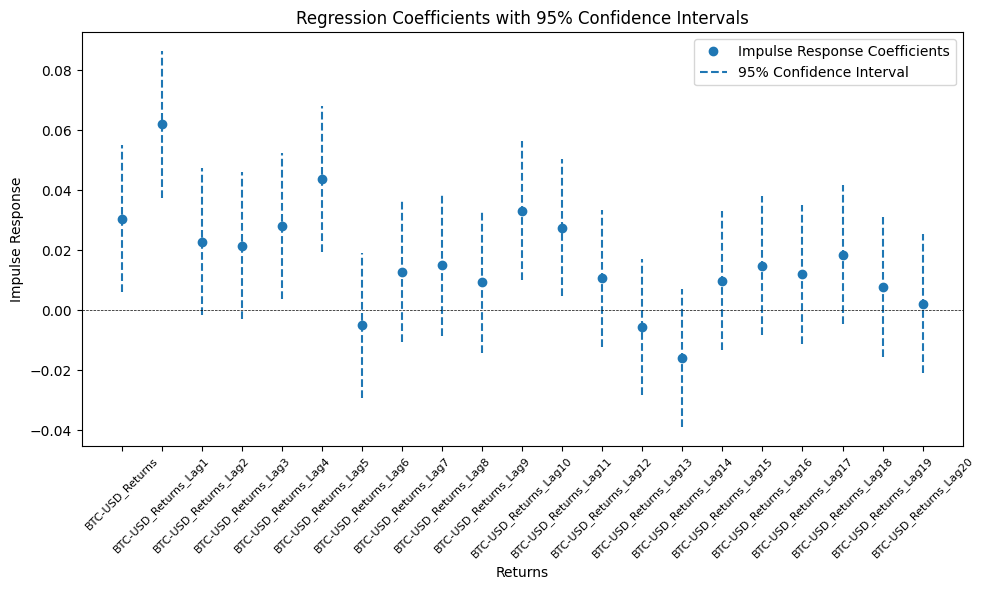

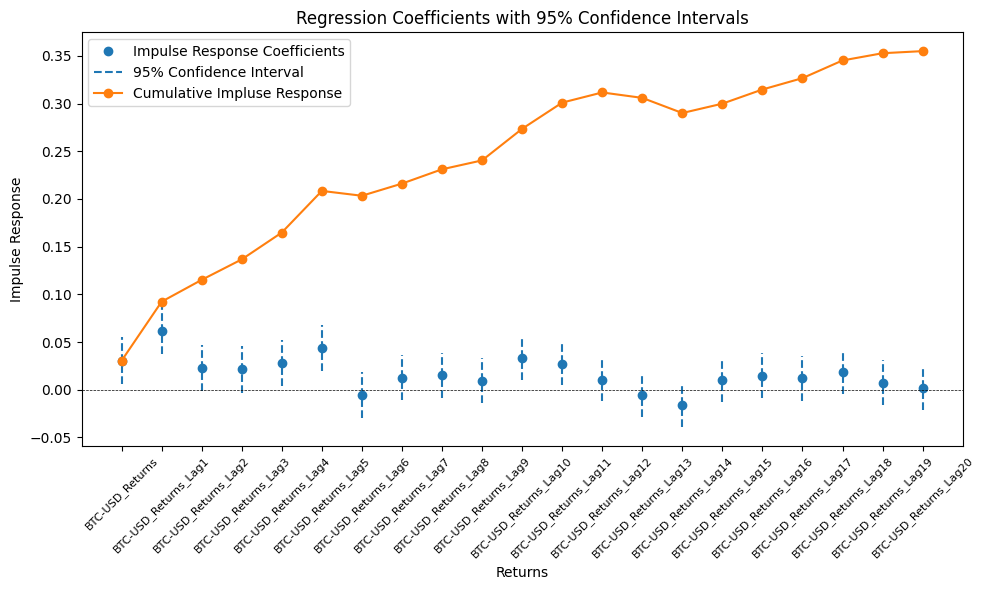

<ipython-input-14-367388d404c6>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate and align labels


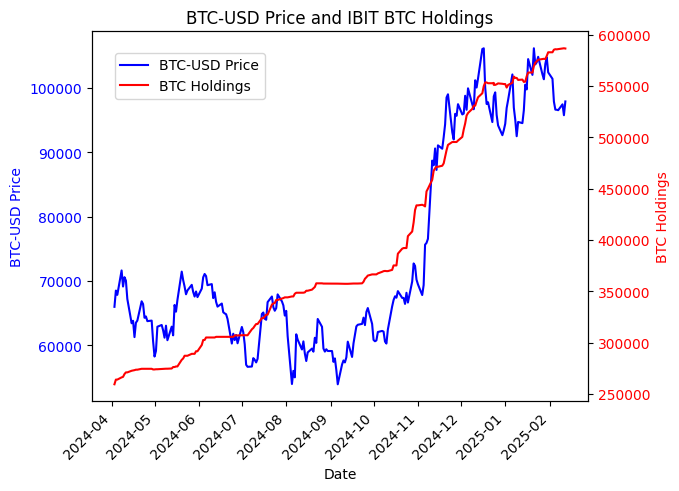

In [14]:
# IBIT Impulse Response
flows = merge_prices(flow_ibit, 'BTC-USD', 20)
model = run_regression(flows, 'BTC-USD', 20)
plot_coefficients(model)
flows['flow_change'].describe()

# Plot Holdings and BTC Price
fig, ax1 = plt.subplots()

# Plot 'BTC-USD' price on the primary y-axis (ax1)
ax1.plot(flows['DateTime'], flows['BTC-USD'], color='blue', label='BTC-USD Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC-USD Price', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis (ax2) for 'BTC holdings'
ax2 = ax1.twinx()
ax2.plot(flows['DateTime'], flows['holdings'], color='red', label='BTC Holdings')
ax2.set_ylabel('BTC Holdings', color='red')
ax2.tick_params('y', labelcolor='red')

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))

# Set the title
plt.title('BTC-USD Price and IBIT BTC Holdings')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate and align labels
# Display the plot
plt.show()





## Futures BTC ETF

[*********************100%***********************]  1 of 1 completed
<ipython-input-5-c06c5b08c2ad>:37: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  flows[f'{token}_Returns'] = flows[f'{token}'].pct_change()


                            OLS Regression Results                            
Dep. Variable:            flow_change   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.7639
Date:                Thu, 06 Mar 2025   Prob (F-statistic):              0.766
Time:                        15:15:41   Log-Likelihood:                 2381.9
No. Observations:                 836   AIC:                            -4720.
Df Residuals:                     814   BIC:                            -4616.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0012    

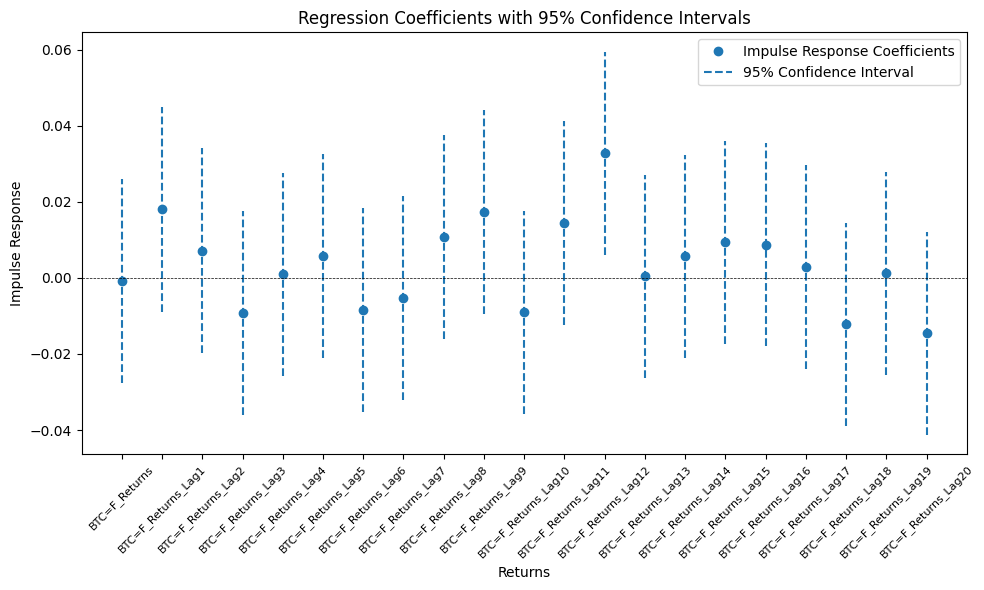

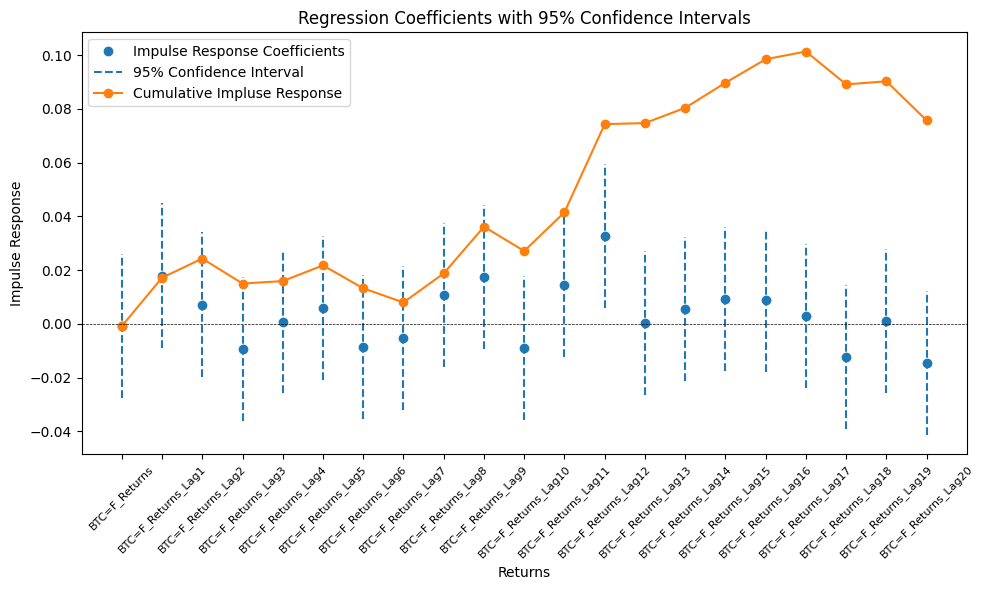

,flow_change
count,836.000000
mean,0.001298
std,0.014154
min,-0.070705
25%,-0.001880
50%,0.000000
75%,0.004308
max,0.121890


<ipython-input-15-bf03e8bf6adb>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate and align labels


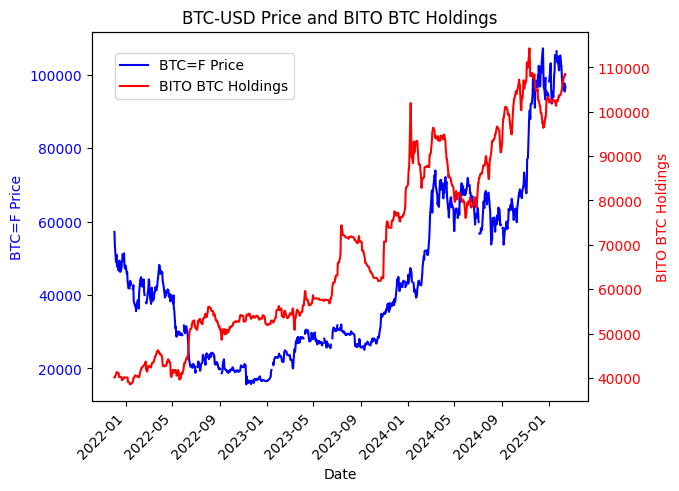

In [15]:

flows = merge_prices(flow_bito, 'BTC=F', 20)
model = run_regression(flows, 'BTC=F', 20)
plot_coefficients(model)
display(flows['flow_change'].describe())

# Assuming 'flows' DataFrame has columns 'DateTime', 'BTC-USD', and 'BTC holdings'

fig, ax1 = plt.subplots()

# Plot 'BTC-USD' price on the primary y-axis (ax1)
ax1.plot(flows['DateTime'], flows['BTC=F'], color='blue', label='BTC=F Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC=F Price', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis (ax2) for 'BTC holdings'
ax2 = ax1.twinx()
ax2.plot(flows['DateTime'], flows['holdings'], color='red', label='BITO BTC Holdings')
ax2.set_ylabel('BITO BTC Holdings', color='red')
ax2.tick_params('y', labelcolor='red')

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate and align labels

# Set the title
plt.title('BTC-USD Price and BITO BTC Holdings')

# Display the plot
plt.show()

## Gold ETF

                            OLS Regression Results                            
Dep. Variable:            flow_change   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     13.07
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           1.02e-44
Time:                        15:15:43   Log-Likelihood:                 19394.
No. Observations:                5246   AIC:                        -3.874e+04
Df Residuals:                    5224   BIC:                        -3.860e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0003   8.44

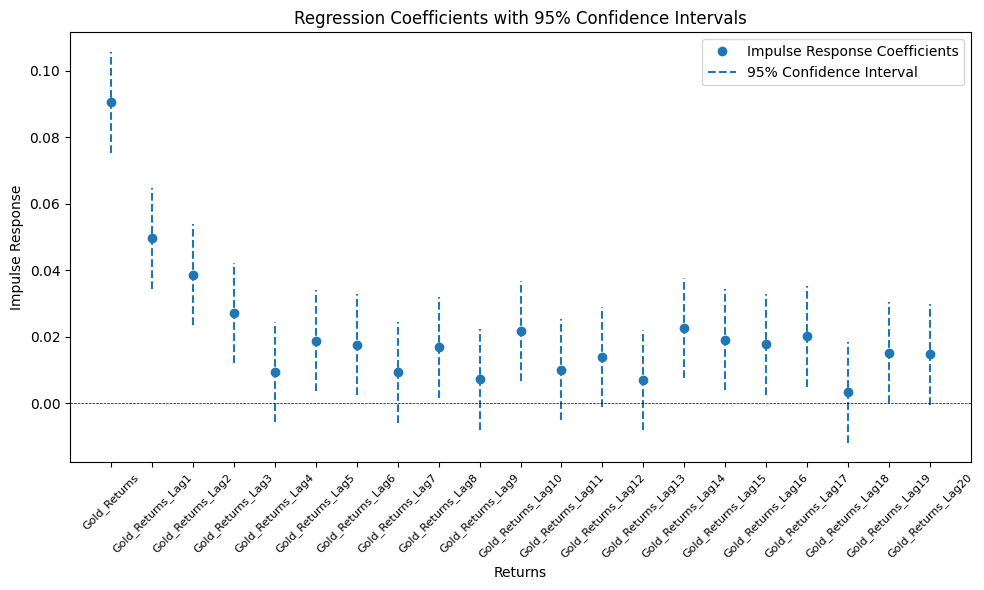

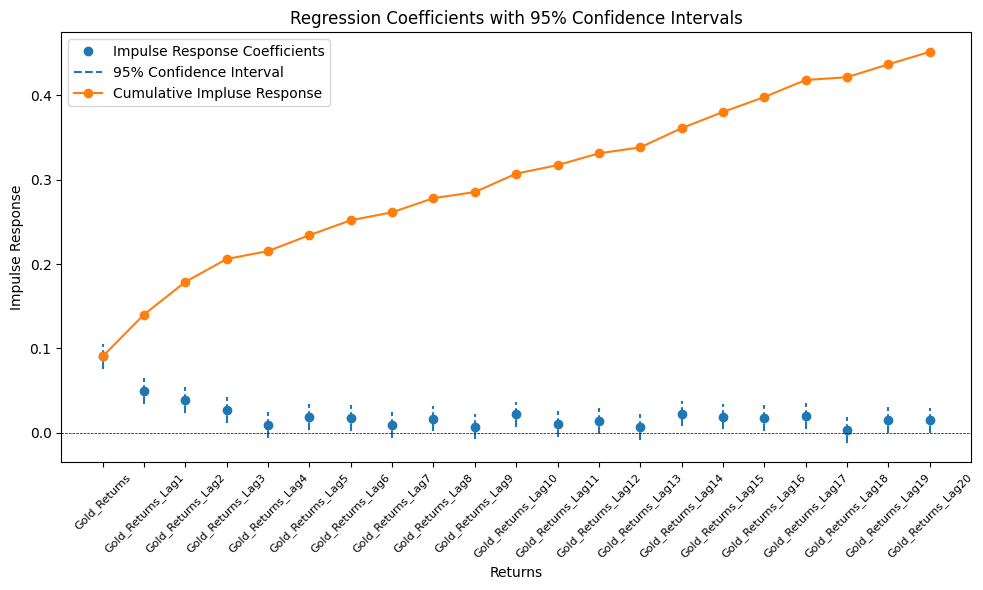

,flow_change
count,5246.000000
mean,0.000452
std,0.006157
min,-0.033606
25%,-0.000344
50%,0.000000
75%,0.000000
max,0.150757


<ipython-input-16-dfeb3ede1d1a>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate and align labels


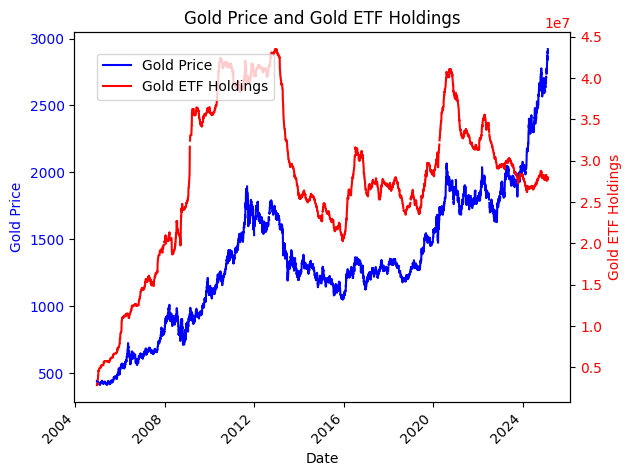

In [16]:
flows = flow_gold
# Define the independent and dependent variables
lags = 20

# Create lagged return variables
for i in range(1, lags + 1):
    flows[f'Gold_Returns_Lag{i}'] = flows[f'Gold_Returns'].shift(i)
flows = flows.dropna(subset = [f'Gold_Returns_Lag{i}' for i in range(1, lags + 1)] + [f'Gold_Returns', 'flow_change'])

model = run_regression(flows, 'Gold', 20)
plot_coefficients(model)
display(flows['flow_change'].describe())

# Assuming 'flows' DataFrame has columns 'DateTime', 'BTC-USD', and 'BTC holdings'

fig, ax1 = plt.subplots()

# Plot 'BTC-USD' price on the primary y-axis (ax1)
ax1.plot(flows.index, flows['LBMA Gold Price'], color='blue', label='Gold Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis (ax2) for 'BTC holdings'
ax2 = ax1.twinx()
ax2.plot(flows.index, flows['Total Net Asset Value Ounces in the Trust as at 4.15 p.m. NYT'], color='red', label='Gold ETF Holdings')
ax2.set_ylabel('Gold ETF Holdings', color='red')
ax2.tick_params('y', labelcolor='red')

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate and align labels

# Set the title
plt.title('Gold Price and Gold ETF Holdings')

# Display the plot
plt.show()

ETH ETF

[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:            flow_change   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     3.568
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           0.000244
Time:                        15:15:44   Log-Likelihood:                 319.06
No. Observations:                 127   AIC:                            -614.1
Df Residuals:                     115   BIC:                            -580.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.01

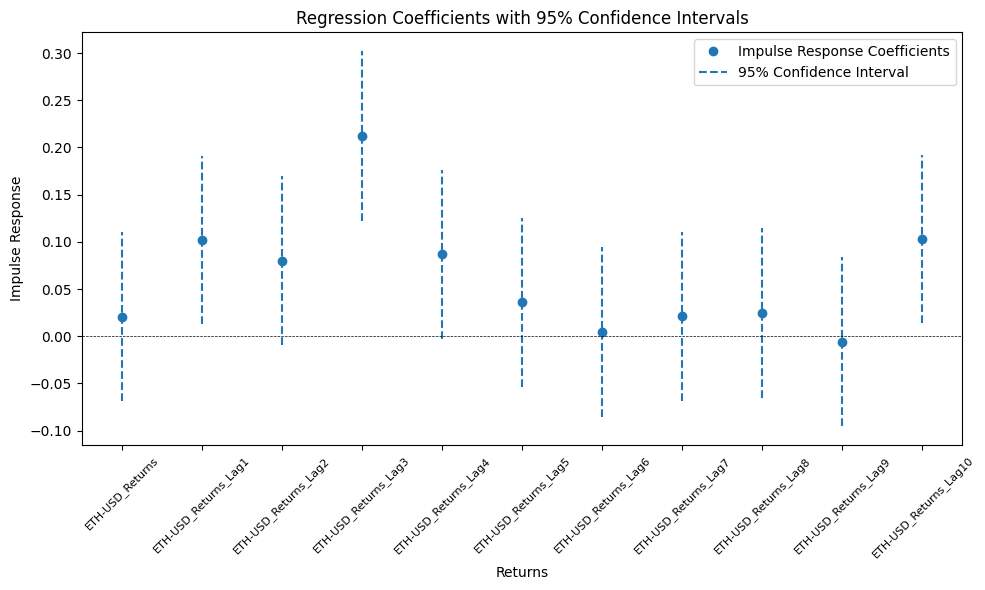

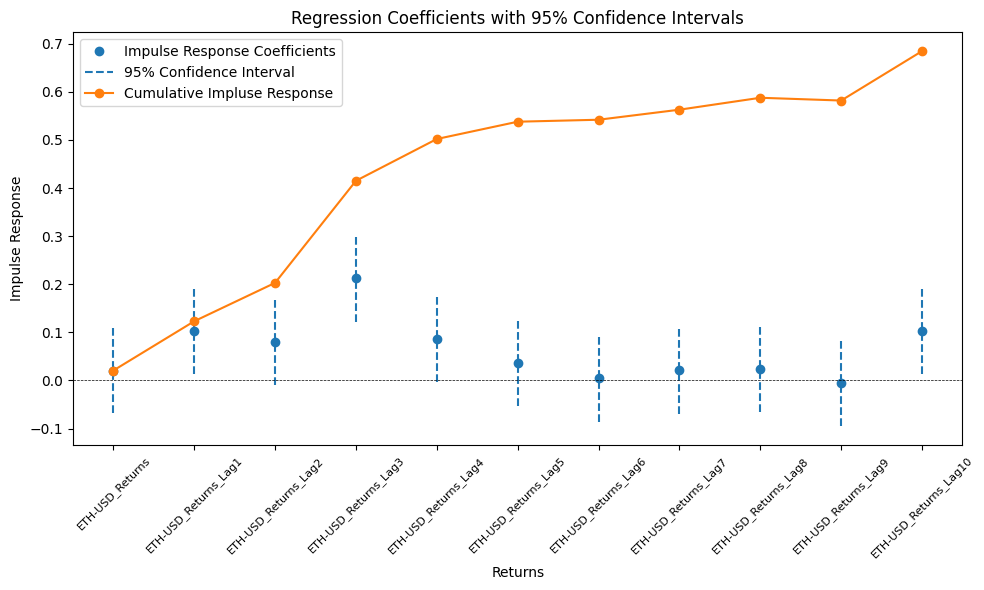

<ipython-input-17-1c5b66e6f022>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate and align labels


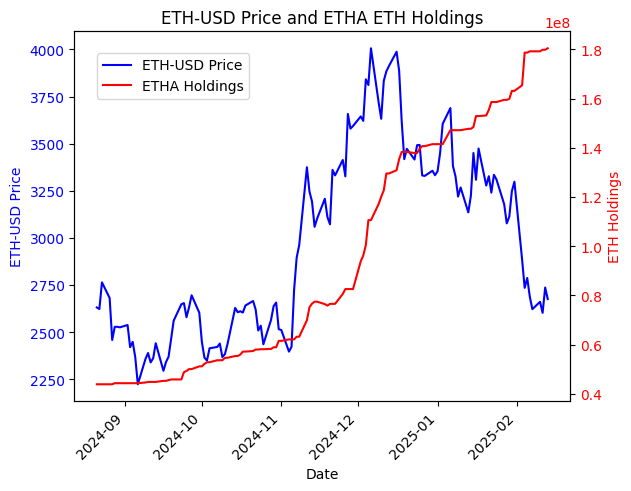

In [17]:
flows = merge_prices(flow_etha, 'ETH-USD', 10)
model = run_regression(flows, 'ETH-USD', 10)
plot_coefficients(model)

# Assuming 'flows' DataFrame has columns 'DateTime', 'ETH-USD', and 'ETH holdings'

fig, ax1 = plt.subplots()

# Plot 'ETH-USD' price on the primary y-axis (ax1)
ax1.plot(flows['DateTime'], flows['ETH-USD'], color='blue', label='ETH-USD Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('ETH-USD Price', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis (ax2) for 'ETH holdings'
ax2 = ax1.twinx()
ax2.plot(flows['DateTime'], flows['holdings'], color='red', label='ETHA Holdings')
ax2.set_ylabel('ETH Holdings', color='red')
ax2.tick_params('y', labelcolor='red')

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))

# Set the title
plt.title('ETH-USD Price and ETHA ETH Holdings')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate and align labels
# Display the plot
plt.show()


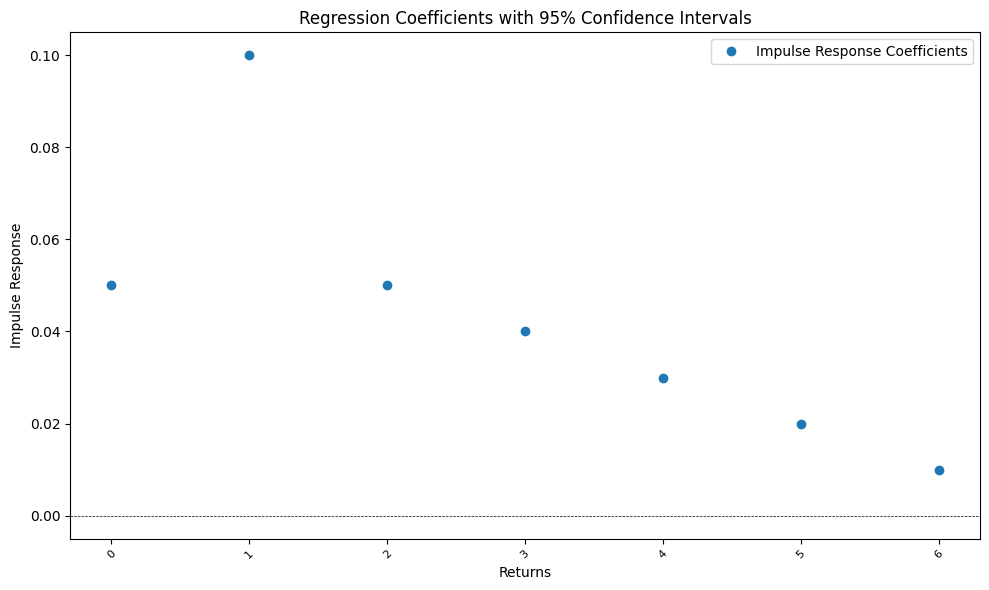

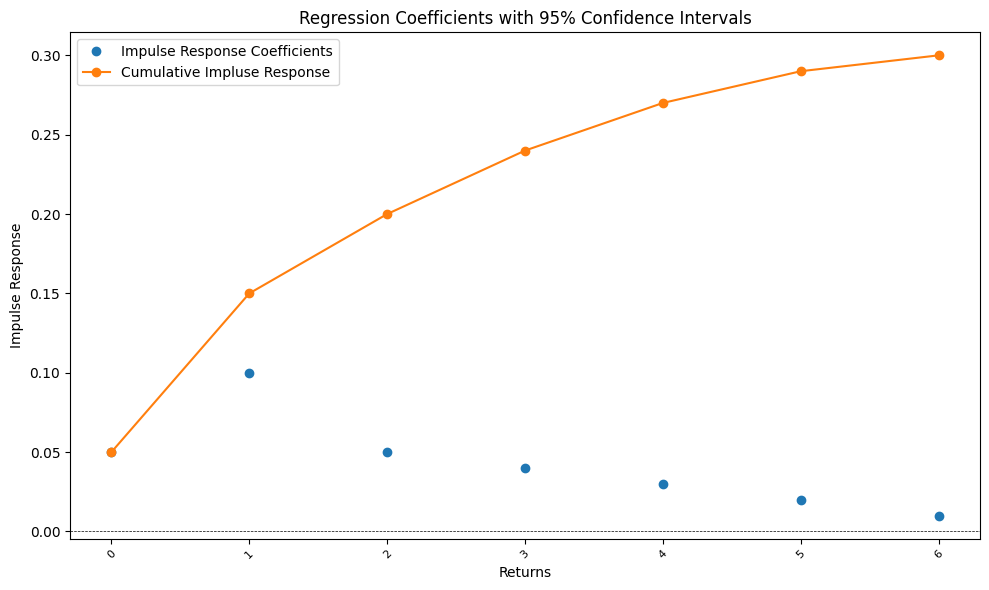

In [18]:
#Estimated Impulse Response Function

impulse_response_estimated = [[0.05,0.1,0.05,0.04,0.03,0.02,0.01],[0,1,2,3,4,5,6]]

coefficients = pd.DataFrame(list(map(list, zip(*impulse_response_estimated))), columns = ['Response', 'Return Lags']).set_index('Return Lags')

# Create a plot

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the coefficients
ax.plot(coefficients.index, coefficients.values, 'o', label='Impulse Response Coefficients')

# Customize the plot
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5) # add a horizontal line at y=0
ax.set_xlabel("Returns")
ax.set_ylabel("Impulse Response")
ax.set_title("Regression Coefficients with 95% Confidence Intervals")
ax.tick_params(axis='x', rotation=45, labelsize=8)
ax.legend()
plt.tight_layout()
plt.show()

# Cumulative Coefficients
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the coefficients
ax.plot(coefficients.index, coefficients.values, 'o', label='Impulse Response Coefficients') # The '-o' changed to 'o-' will produce the line for the dots

# Calculate and plot cumulative coefficients
cumulative_coefficients = coefficients.cumsum()
ax.plot(cumulative_coefficients.index, cumulative_coefficients.values,
        marker='o', linestyle='-', label='Cumulative Impluse Response')

# Customize the plot
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax.set_xlabel("Returns")
ax.set_ylabel("Impulse Response")
ax.set_title("Regression Coefficients with 95% Confidence Intervals")
ax.tick_params(axis='x', rotation=45, labelsize=8)
ax.legend()
plt.tight_layout()
plt.show()



In [19]:
list(map(list, zip(*impulse_response_estimated)))

[[0.05, 0], [0.1, 1], [0.05, 2], [0.04, 3], [0.03, 4], [0.02, 5], [0.01, 6]]

# 2-22 Event


In [20]:
# During the week of 2-20-2025, ETH price dropped 20% over 3 days. We analyse holdings around those dates

eth_price = pd.DataFrame(data = [['02/20/2025',180440000,20.841261, 1033920000, 56.023084],['02/21/2025',180440000,20.021633,1031920000 ,54.102615],['02/24/2025', 180440000,20.086402, 1032320000,53.578301 ],['02/25/2025',178040000,18.826536, 1029360000, 50.112655], ['02/26/2025',178040000, 17.439869, 1026080000, 47.506431],['02/27/2025', 174040000, 17.145522, 1017280000,47.254901]], columns = ['Date','ETHA Holdings', 'ETHA Price', 'IBIT Holdings', 'IBIT Price'])

#eth_price['Date'] = pd.to_datetime(eth_price['Date'])
eth_price.set_index('Date', inplace=True)
eth_price['ETHA Holdings'] = eth_price['ETHA Holdings'].astype(float)
eth_price['ETHA Price'] = eth_price['ETHA Price'].astype(float)

eth_price['ETHA Holdings (100)'] = 100* eth_price['ETHA Holdings']/eth_price['ETHA Holdings'][0]
eth_price['ETHA Price (100)'] = 100* eth_price['ETHA Price']/eth_price['ETHA Price'][0]

eth_price['IBIT Holdings (100)'] = 100* eth_price['IBIT Holdings']/eth_price['IBIT Holdings'][0]
eth_price['IBIT Price (100)'] = 100* eth_price['IBIT Price']/eth_price['IBIT Price'][0]



<ipython-input-20-e9a42d933020>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eth_price['ETHA Holdings (100)'] = 100* eth_price['ETHA Holdings']/eth_price['ETHA Holdings'][0]
<ipython-input-20-e9a42d933020>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eth_price['ETHA Price (100)'] = 100* eth_price['ETHA Price']/eth_price['ETHA Price'][0]
<ipython-input-20-e9a42d933020>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eth_p

In [21]:
eth_price

,ETHA Holdings,ETHA Price,IBIT Holdings,IBIT Price,ETHA Holdings (100),ETHA Price (100),IBIT Holdings (100),IBIT Price (100)
Date,,,,,,,,
02/20/2025,180440000.0,20.841261,1033920000,56.023084,100.000000,100.000000,100.000000,100.000000
02/21/2025,180440000.0,20.021633,1031920000,54.102615,100.000000,96.067282,99.806561,96.572004
02/24/2025,180440000.0,20.086402,1032320000,53.578301,100.000000,96.378055,99.845249,95.636115
02/25/2025,178040000.0,18.826536,1029360000,50.112655,98.669918,90.332999,99.558960,89.450011
02/26/2025,178040000.0,17.439869,1026080000,47.506431,98.669918,83.679529,99.241721,84.797958
02/27/2025,174040000.0,17.145522,1017280000,47.254901,96.453115,82.267201,98.390591,84.348982


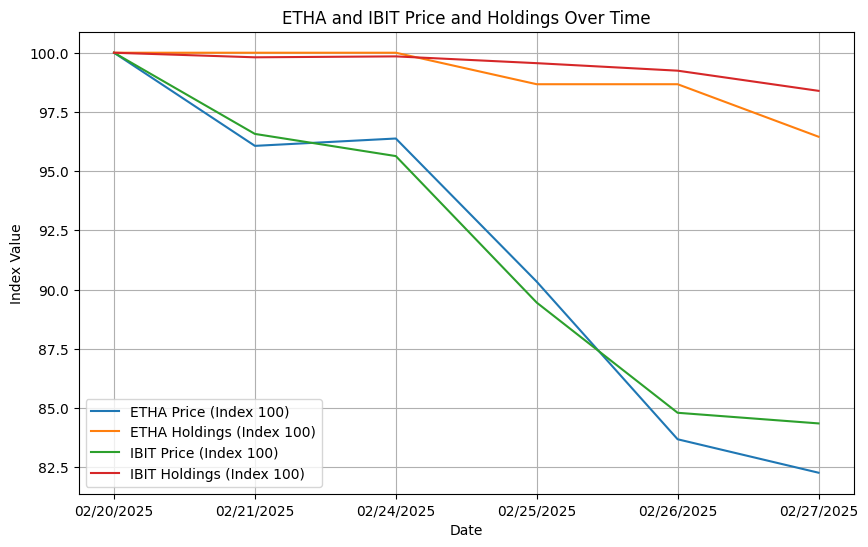

In [22]:

# Assuming eth_price DataFrame is already defined as in the provided code

plt.figure(figsize=(10, 6))
plt.plot(eth_price.index, eth_price['ETHA Price (100)'], label='ETHA Price (Index 100)')
plt.plot(eth_price.index, eth_price['ETHA Holdings (100)'], label='ETHA Holdings (Index 100)')
plt.plot(eth_price.index, eth_price['IBIT Price (100)'], label='IBIT Price (Index 100)')
plt.plot(eth_price.index, eth_price['IBIT Holdings (100)'], label='IBIT Holdings (Index 100)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('ETHA and IBIT Price and Holdings Over Time')
plt.legend()
plt.grid(True)
plt.show()
